In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.9.1
sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.0
pandas 1.4.3
sklearn 1.1.1
tensorflow 2.9.1
keras.api._v2.keras 2.9.0


In [ ]:
# 在这个库中，tf帮我们定义很多数据集，这些数据集是以dataset来存储的
# https://tensorflow.google.cn/datasets/catalog/overview
import tensorflow_datasets as tfds

# 仍然是电影的二分类问题
# 我们可以到数据集中去看imdb_reviews/subwords8k的信息
# with_info if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) 
# containing the info associated with the builder.
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info = True,
                          # as_supervised代表有监督的，会把labels，也就是结果返回
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

In [5]:
# 通过encoder把我们的词语转换为subword形式，vocab_size就是字典大小
tokenizer = info.features['text'].encoder
print('vocabulary size: {}'.format(tokenizer.vocab_size))

vocabulary size: 8185


In [4]:
type(tokenizer)

tensorflow_datasets.core.features.text.subword_text_encoder.SubwordTextEncoder

In [7]:
for i in train_dataset.take(1):
    print(np.array(i[0]))
    print(len(i[0]))
    print(tokenizer.decode(np.array(i[0])))

[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
163
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in h

In [8]:
# subword level不可以去除标点符号
sample_string = 'Tensorflow is cool.'
# encode是变为id序列
tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))
print(type(tokenized_string))
# decode又变为原来的字符串
original_string = tokenizer.decode(tokenized_string)
print('Original string is {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 2934, 7961, 9, 2724, 7975]
<class 'list'>
Original string is Tensorflow is cool.


In [9]:
# for循环看下每个id
for token in tokenized_string:
    print('{} --> {}--{}'.format(token, tokenizer.decode([token]),len(tokenizer.decode([token]))))

6307 --> Ten--3
2327 --> sor--3
2934 --> flow--4
7961 -->  --1
9 --> is --3
2724 --> cool--4
7975 --> .--1


In [17]:
buffer_size = 10000
batch_size = 64

padded_shapes=tf.compat.v1.data.get_output_shapes(train_dataset)
padded_shapes_test=tf.compat.v1.data.get_output_shapes(test_dataset)
print(train_dataset)
print(test_dataset)

# 自动填充到最大大小,每批里边的最大值
train_dataset = train_dataset.shuffle(buffer_size)  # 做dataset洗牌
# padded_batch是每批数据分别做padding
train_dataset = train_dataset.padded_batch(batch_size,padded_shapes) 

test_dataset = test_dataset.padded_batch(batch_size,padded_shapes_test)

<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>
<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>


In [18]:
for i in train_dataset.take(10):
    print(np.array(i))

[[<tf.Tensor: shape=(1529,), dtype=int64, numpy=array([ 12, 304,   1, ...,   0,   0,   0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([ 518, 1693,    1, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([1698, 7973,   26, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([156,  37, 783, ...,   0,   0,   0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([  19, 1852, 6912, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([ 274,    1, 7999, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([1504, 4202, 7968, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([ 12,  18, 140, ...,   0,   0,   0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([2162, 7961, 1597, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1529,), dtype=int64, numpy=array([  12, 2135,    1, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1529,), dtype=int

[[<tf.Tensor: shape=(1354,), dtype=int64, numpy=array([  19, 7875, 7961, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([62, 27, 18, ...,  0,  0,  0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([4023, 7961,  321, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([5586,  636, 8039, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([62, 27, 57, ...,  0,  0,  0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([  12, 2515,    1, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([2911,  319, 3176, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([62, 18,  4, ...,  0,  0,  0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([  12, 5564,   36, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([7963, 1292,   40, ...,    0,    0,    0])>
  <tf.Tensor: shape=(1354,), dtype=int64, numpy=array([1

In [24]:
vocab_size = tokenizer.vocab_size  # 8165
embedding_dim = 16

bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 145,617
Trainable params: 145,617
Non-trainable params: 0
_________________________________________________________________


In [25]:
bi_rnn_model.variables

[<tf.Variable 'embedding/embeddings:0' shape=(8185, 16) dtype=float32, numpy=
 array([[-0.0455155 , -0.00878084, -0.01052933, ...,  0.00707464,
         -0.01941682,  0.04153192],
        [-0.01417323,  0.01322405, -0.02466459, ...,  0.00969439,
          0.00148557,  0.00086799],
        [ 0.03672918, -0.00424031, -0.0305648 , ..., -0.0267274 ,
          0.02268685,  0.02390367],
        ...,
        [-0.01355215,  0.01764799,  0.01301089, ..., -0.00434384,
          0.04438056,  0.04807161],
        [-0.01339499, -0.01868153,  0.00841212, ..., -0.0058774 ,
          0.04740315,  0.00269805],
        [ 0.02590329, -0.03069422, -0.00517488, ...,  0.014438  ,
          0.04331307, -0.03891591]], dtype=float32)>,
 <tf.Variable 'bidirectional/forward_lstm/lstm_cell_1/kernel:0' shape=(16, 128) dtype=float32, numpy=
 array([[ 0.07465681, -0.13744837,  0.05019575, ..., -0.13636184,
          0.17282996,  0.03382015],
        [ 0.16101071, -0.06697571,  0.16492206, ...,  0.14685893,
         

In [26]:
8185*16

130960

In [3]:
16*128+32*128+128

6272

In [4]:
6272*2

12544

In [7]:
history = bi_rnn_model.fit(
    train_dataset,
    # 因为之前30次过拟合，这里改为10次
    epochs = 10,
    validation_data = test_dataset)

Epoch 1/10
391/391 [==============================] - 500s 1s/step - loss: 0.5268 - accuracy: 0.7230 - val_loss: 0.4158 - val_accuracy: 0.8195
Epoch 2/10
391/391 [==============================] - 442s 1s/step - loss: 0.3337 - accuracy: 0.8651 - val_loss: 0.3667 - val_accuracy: 0.8486
Epoch 3/10
391/391 [==============================] - 366s 937ms/step - loss: 0.2566 - accuracy: 0.9041 - val_loss: 0.3892 - val_accuracy: 0.8319
Epoch 4/10
391/391 [==============================] - 309s 791ms/step - loss: 0.2137 - accuracy: 0.9246 - val_loss: 0.4307 - val_accuracy: 0.8392
Epoch 5/10
391/391 [==============================] - 312s 797ms/step - loss: 0.1774 - accuracy: 0.9402 - val_loss: 0.4169 - val_accuracy: 0.8245
Epoch 6/10
391/391 [==============================] - 318s 813ms/step - loss: 0.1635 - accuracy: 0.9441 - val_loss: 0.5590 - val_accuracy: 0.7795
Epoch 7/10
391/391 [==============================] - 344s 881ms/step - loss: 0.1610 - accuracy: 0.9441 - val_loss: 0.5112 - val_a

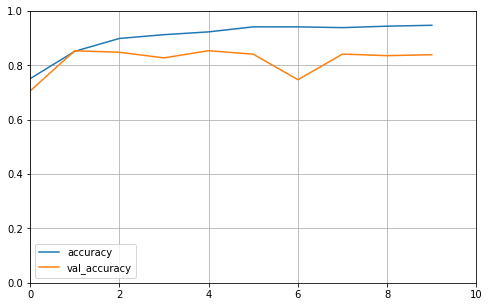

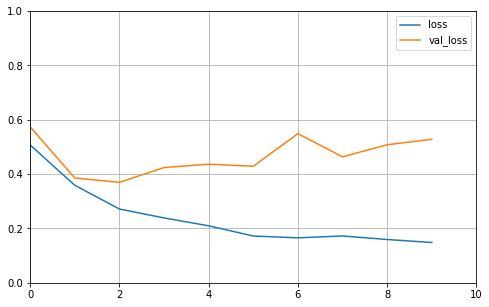

In [12]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', 10, 0, 1)
plot_learning_curves(history, 'loss', 10, 0, 1)
# 过拟合现象相对之前弱一些

In [13]:
bi_rnn_model.evaluate(test_dataset)

391/391 [==============================] - 47s 121ms/step - loss: 0.5278 - accuracy: 0.8393


[0.527801513671875, 0.8392800092697144]